In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from typing import Dict
import pandas as pd

In [3]:
import run_sampler, models, data_utils

/Users/mandar/.venvs/covid/lib/python3.8/site-packages/prettyprinter/__init__.py:337: UserWarning: Failed to install 'python' PrettyPrinter extra. If you don't need it, call install_extras with exclude=['python']
  warnings.warn(


In [4]:
state = "Kerala" # "Maharashtra"
MH_pop = 34800000  # 112374333
start_date = datetime.datetime(2021, 1, 1)

In [5]:
analysis = run_sampler.tuning_exp(
    state,
    MH_pop,
    start_date=start_date,
    num_samples=75
)

2021-05-05 19:37:50,769	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265
2021-05-05 19:37:52,681	WARNING function_runner.py:544 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho
_tuning_fn_9e5d6_00000,RUNNING,,1.13207,0.242745,0.0251584,0.53698,0.0384155,0.332519,0.000588985
_tuning_fn_9e5d6_00001,PENDING,,1.06362,0.0887332,0.0285731,0.521478,0.0229402,0.639249,0.000349874
_tuning_fn_9e5d6_00002,PENDING,,0.942214,0.208372,0.0181186,0.520978,0.0111277,0.38417,0.000621191
_tuning_fn_9e5d6_00003,PENDING,,0.957884,0.318288,0.0251106,0.276901,0.0430701,0.338406,0.000488998
_tuning_fn_9e5d6_00004,PENDING,,1.02512,0.178024,0.019344,0.453102,0.0101017,0.497556,0.000101698
_tuning_fn_9e5d6_00005,PENDING,,0.988063,0.0690728,0.0411301,0.273923,0.0461224,0.423619,0.00043176
_tuning_fn_9e5d6_00006,PENDING,,0.881046,0.100395,0.011804,0.438729,0.0398147,0.790294,0.000183894
_tuning_fn_9e5d6_00007,PENDING,,0.937129,0.324873,0.0330082,0.337147,0.0219385,0.716268,0.000257499
_tuning_fn_9e5d6_00008,PENDING,,1.04789,0.283527,0.0178764,0.296582,0.0424544,0.488565,0.000925019
_tuning_fn_9e5d6_00009,PENDING,,1.16761,0.216556,0.0368208,0.533957,0.0144715,0.671785,0.000721591


Result for _tuning_fn_9e5d6_00000:
  date: 2021-05-05_19-37-55
  done: false
  experiment_id: 8af0c36fa2d04bdb98a2975f362afa9a
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.5841155662143946
  node_ip: 192.168.192.62
  pid: 6846
  time_since_restore: 0.06900286674499512
  time_this_iter_s: 0.06900286674499512
  time_total_s: 0.06900286674499512
  timestamp: 1620236275
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00000
  
Result for _tuning_fn_9e5d6_00000:
  date: 2021-05-05_19-37-55
  done: true
  experiment_id: 8af0c36fa2d04bdb98a2975f362afa9a
  experiment_tag: 0_beta=1.1321,eps=0.24274,mu=0.025158,p_a=0.53698,p_d=0.038415,r_b=0.33252,rho=0.00058899
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.5841155662143946
  node_ip: 192.168.192.62
  pid: 6846
  time_since_restore: 0.06900286674499512
  time_this_iter_s: 0.06900286674499512
  time_total_s: 0.06900286674499512
  timestamp: 1620236275
  tim

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00008,RUNNING,,1.04789,0.283527,0.0178764,0.296582,0.0424544,0.488565,0.000925019,,,
_tuning_fn_9e5d6_00009,RUNNING,,1.16761,0.216556,0.0368208,0.533957,0.0144715,0.671785,0.000721591,,,
_tuning_fn_9e5d6_00010,RUNNING,,1.01145,0.120449,0.0409567,0.378257,0.0316475,0.771045,0.000418107,,,
_tuning_fn_9e5d6_00011,RUNNING,,0.980117,0.157472,0.0234096,0.406522,0.011473,0.569032,0.000563375,,,
_tuning_fn_9e5d6_00012,RUNNING,,1.16924,0.288983,0.0467688,0.618847,0.0123296,0.352051,0.000678469,,,
_tuning_fn_9e5d6_00013,RUNNING,,1.03166,0.246451,0.0432302,0.698549,0.0442411,0.586958,0.000109359,,,
_tuning_fn_9e5d6_00014,RUNNING,,1.17926,0.161037,0.0181444,0.686281,0.0425129,0.407433,0.000142444,,,
_tuning_fn_9e5d6_00016,PENDING,,0.907225,0.071741,0.032208,0.667379,0.0303376,0.393569,0.0007973,,,
_tuning_fn_9e5d6_00017,PENDING,,1.02504,0.196286,0.0225758,0.54192,0.0284502,0.548614,0.000532002,,,
_tuning_fn_9e5d6_00018,PENDING,,0.823783,0.25869,0.0212763,0.449138,0.0370424,0.579321,0.000104271,,,


Result for _tuning_fn_9e5d6_00015:
  date: 2021-05-05_19-38-00
  done: false
  experiment_id: e8c7e62af7b64a00a45a3bf03ff02ff5
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.486580899592399
  node_ip: 192.168.192.62
  pid: 6870
  time_since_restore: 0.08520126342773438
  time_this_iter_s: 0.08520126342773438
  time_total_s: 0.08520126342773438
  timestamp: 1620236280
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00015
  
Result for _tuning_fn_9e5d6_00013:
  date: 2021-05-05_19-38-00
  done: false
  experiment_id: ab78fc560caa4dcc949155c33afcc412
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.702915435847406
  node_ip: 192.168.192.62
  pid: 6872
  time_since_restore: 0.0899503231048584
  time_this_iter_s: 0.0899503231048584
  time_total_s: 0.0899503231048584
  timestamp: 1620236280
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00013
  
Result for _tuning_fn_9e5d6_00015:
  

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00016,RUNNING,,0.907225,0.071741,0.032208,0.667379,0.0303376,0.393569,0.0007973,,,
_tuning_fn_9e5d6_00017,RUNNING,,1.02504,0.196286,0.0225758,0.54192,0.0284502,0.548614,0.000532002,,,
_tuning_fn_9e5d6_00018,RUNNING,,0.823783,0.25869,0.0212763,0.449138,0.0370424,0.579321,0.000104271,,,
_tuning_fn_9e5d6_00019,RUNNING,,0.910521,0.261896,0.023286,0.670514,0.0150095,0.438276,0.000733065,,,
_tuning_fn_9e5d6_00020,RUNNING,,0.934878,0.323565,0.0492012,0.48047,0.0128348,0.370561,0.000759279,,,
_tuning_fn_9e5d6_00021,RUNNING,,1.12922,0.187327,0.0294955,0.508485,0.0413817,0.313543,0.000169249,,,
_tuning_fn_9e5d6_00022,RUNNING,,0.944716,0.278721,0.0423502,0.639124,0.0298381,0.670929,0.000118348,,,
_tuning_fn_9e5d6_00024,PENDING,,1.13907,0.11334,0.0136985,0.468754,0.0165587,0.727867,0.000909555,,,
_tuning_fn_9e5d6_00025,PENDING,,1.15117,0.180899,0.0287599,0.629966,0.0405916,0.776381,0.000254884,,,
_tuning_fn_9e5d6_00026,PENDING,,1.19569,0.272618,0.0454725,0.645287,0.0122507,0.391194,0.000369475,,,


Result for _tuning_fn_9e5d6_00016:
  date: 2021-05-05_19-38-05
  done: false
  experiment_id: f0bd994a0809463d8c050b1fe0f944ae
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 1.5900260510182145
  node_ip: 192.168.192.62
  pid: 6916
  time_since_restore: 0.055316925048828125
  time_this_iter_s: 0.055316925048828125
  time_total_s: 0.055316925048828125
  timestamp: 1620236285
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00016
  
Result for _tuning_fn_9e5d6_00022:
  date: 2021-05-05_19-38-04
  done: false
  experiment_id: 8052a6289a794849b6d06f657b99e724
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.7497989620924024
  node_ip: 192.168.192.62
  pid: 6905
  time_since_restore: 0.08717584609985352
  time_this_iter_s: 0.08717584609985352
  time_total_s: 0.08717584609985352
  timestamp: 1620236284
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00022
  
Result for _tuning_fn_9e5d6_0

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00024,RUNNING,,1.13907,0.11334,0.0136985,0.468754,0.0165587,0.727867,0.000909555,,,
_tuning_fn_9e5d6_00025,RUNNING,,1.15117,0.180899,0.0287599,0.629966,0.0405916,0.776381,0.000254884,,,
_tuning_fn_9e5d6_00026,RUNNING,,1.19569,0.272618,0.0454725,0.645287,0.0122507,0.391194,0.000369475,,,
_tuning_fn_9e5d6_00027,RUNNING,,0.985918,0.267625,0.0415899,0.596872,0.0296896,0.656172,0.000353381,,,
_tuning_fn_9e5d6_00028,RUNNING,192.168.192.62:6938,1.03221,0.0966268,0.0489218,0.344655,0.0374711,0.321686,0.000149799,1,0.0883961,2.10955
_tuning_fn_9e5d6_00029,RUNNING,,0.790858,0.147461,0.0181351,0.473536,0.0108341,0.798185,0.000308758,,,
_tuning_fn_9e5d6_00030,RUNNING,,0.997715,0.245327,0.0100659,0.554569,0.0311842,0.527937,0.000484891,,,
_tuning_fn_9e5d6_00032,PENDING,,0.868885,0.103911,0.0453379,0.495214,0.0406268,0.462648,0.000122182,,,
_tuning_fn_9e5d6_00033,PENDING,,0.834841,0.108115,0.0138403,0.505494,0.0272479,0.441579,0.00021677,,,
_tuning_fn_9e5d6_00034,PENDING,,0.964958,0.212023,0.0237401,0.421668,0.0366427,0.678342,0.000334962,,,


Result for _tuning_fn_9e5d6_00028:
  date: 2021-05-05_19-38-09
  done: true
  experiment_id: c7621391901148879a55eb1b16a8aa41
  experiment_tag: 28_beta=1.0322,eps=0.096627,mu=0.048922,p_a=0.34465,p_d=0.037471,r_b=0.32169,rho=0.0001498
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.1095486734146407
  node_ip: 192.168.192.62
  pid: 6938
  time_since_restore: 0.08839607238769531
  time_this_iter_s: 0.08839607238769531
  time_total_s: 0.08839607238769531
  timestamp: 1620236289
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00028
  
Result for _tuning_fn_9e5d6_00031:
  date: 2021-05-05_19-38-10
  done: false
  experiment_id: 13ebd3f0d1244cda80c4d2742e3ffcf2
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.5819063649255334
  node_ip: 192.168.192.62
  pid: 6937
  time_since_restore: 0.09115099906921387
  time_this_iter_s: 0.09115099906921387
  time_total_s: 0.09115099906921387
  timestamp: 1620236290
  ti

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00032,RUNNING,,0.868885,0.103911,0.0453379,0.495214,0.0406268,0.462648,0.000122182,,,
_tuning_fn_9e5d6_00033,RUNNING,,0.834841,0.108115,0.0138403,0.505494,0.0272479,0.441579,0.00021677,,,
_tuning_fn_9e5d6_00034,RUNNING,,0.964958,0.212023,0.0237401,0.421668,0.0366427,0.678342,0.000334962,,,
_tuning_fn_9e5d6_00035,RUNNING,,0.816268,0.112852,0.0374438,0.687265,0.0251626,0.627645,0.000169379,,,
_tuning_fn_9e5d6_00036,RUNNING,,1.19022,0.223462,0.0422845,0.566588,0.0473522,0.363729,0.000117575,,,
_tuning_fn_9e5d6_00037,RUNNING,,1.10332,0.248884,0.0238994,0.646757,0.0108975,0.317733,0.000108108,,,
_tuning_fn_9e5d6_00038,RUNNING,192.168.192.62:6975,0.930403,0.213676,0.0467612,0.69352,0.0140839,0.672427,0.000156804,1,0.087786,2.6295
_tuning_fn_9e5d6_00040,PENDING,,1.19799,0.203302,0.0395481,0.395346,0.0159922,0.335393,0.0004372,,,
_tuning_fn_9e5d6_00041,PENDING,,0.97416,0.184769,0.0352259,0.29578,0.0143428,0.659766,0.000168099,,,
_tuning_fn_9e5d6_00042,PENDING,,0.856806,0.316265,0.0107813,0.398713,0.0318294,0.460136,0.000451774,,,


Result for _tuning_fn_9e5d6_00037:
  date: 2021-05-05_19-38-15
  done: false
  experiment_id: 6437ad08988e4457b3216b0d245abc4b
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.5374123557401256
  node_ip: 192.168.192.62
  pid: 6977
  time_since_restore: 0.10689091682434082
  time_this_iter_s: 0.10689091682434082
  time_total_s: 0.10689091682434082
  timestamp: 1620236295
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00037
  
Result for _tuning_fn_9e5d6_00035:
  date: 2021-05-05_19-38-15
  done: false
  experiment_id: 3d82ae841e614e4e96dbd714e5a0b857
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.0887556847211113
  node_ip: 192.168.192.62
  pid: 6976
  time_since_restore: 0.08162689208984375
  time_this_iter_s: 0.08162689208984375
  time_total_s: 0.08162689208984375
  timestamp: 1620236295
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00035
  
Result for _tuning_fn_9e5d6_0003

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00040,RUNNING,,1.19799,0.203302,0.0395481,0.395346,0.0159922,0.335393,0.0004372,,,
_tuning_fn_9e5d6_00041,RUNNING,,0.97416,0.184769,0.0352259,0.29578,0.0143428,0.659766,0.000168099,,,
_tuning_fn_9e5d6_00042,RUNNING,,0.856806,0.316265,0.0107813,0.398713,0.0318294,0.460136,0.000451774,,,
_tuning_fn_9e5d6_00043,RUNNING,,1.07143,0.272365,0.040712,0.539384,0.0419542,0.555878,0.000219802,,,
_tuning_fn_9e5d6_00044,RUNNING,,1.09341,0.300292,0.0435751,0.410672,0.0347043,0.790375,0.000401357,,,
_tuning_fn_9e5d6_00045,RUNNING,,1.02234,0.32977,0.0109518,0.47502,0.0395873,0.494499,0.000162639,,,
_tuning_fn_9e5d6_00046,RUNNING,,0.961266,0.183597,0.0293129,0.55954,0.0296871,0.304452,0.000823391,,,
_tuning_fn_9e5d6_00048,PENDING,,0.825157,0.141802,0.0324382,0.374025,0.0328288,0.669512,0.000103295,,,
_tuning_fn_9e5d6_00049,PENDING,,1.106,0.221449,0.0287699,0.279533,0.0487754,0.617423,0.000139629,,,
_tuning_fn_9e5d6_00050,PENDING,,0.811824,0.109939,0.0279319,0.490681,0.0204942,0.461804,0.000507804,,,


Result for _tuning_fn_9e5d6_00047:
  date: 2021-05-05_19-38-20
  done: true
  experiment_id: 26828495f8de4bc2bd9a753aa36dbddb
  experiment_tag: 47_beta=1.0351,eps=0.25422,mu=0.024835,p_a=0.37006,p_d=0.015691,r_b=0.69383,rho=0.00054649
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.704793234440637
  node_ip: 192.168.192.62
  pid: 7006
  time_since_restore: 0.08588600158691406
  time_this_iter_s: 0.08588600158691406
  time_total_s: 0.08588600158691406
  timestamp: 1620236300
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00047
  
Result for _tuning_fn_9e5d6_00046:
  date: 2021-05-05_19-38-20
  done: false
  experiment_id: 3150a29c34de483fa2087ec5a0c61c97
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.334254172432522
  node_ip: 192.168.192.62
  pid: 7008
  time_since_restore: 0.09571719169616699
  time_this_iter_s: 0.09571719169616699
  time_total_s: 0.09571719169616699
  timestamp: 1620236300
  time

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00048,RUNNING,,0.825157,0.141802,0.0324382,0.374025,0.0328288,0.669512,0.000103295,,,
_tuning_fn_9e5d6_00049,RUNNING,,1.106,0.221449,0.0287699,0.279533,0.0487754,0.617423,0.000139629,,,
_tuning_fn_9e5d6_00050,RUNNING,,0.811824,0.109939,0.0279319,0.490681,0.0204942,0.461804,0.000507804,,,
_tuning_fn_9e5d6_00051,RUNNING,,0.752804,0.326733,0.0445644,0.500345,0.0230191,0.602229,0.000185315,,,
_tuning_fn_9e5d6_00052,RUNNING,,0.893534,0.095406,0.0245544,0.299378,0.0354987,0.34489,0.000266606,,,
_tuning_fn_9e5d6_00053,RUNNING,,0.807481,0.284036,0.0452418,0.353324,0.0152079,0.384577,0.000196282,,,
_tuning_fn_9e5d6_00054,RUNNING,,1.19548,0.113917,0.0367664,0.534686,0.0205594,0.641467,0.000217033,,,
_tuning_fn_9e5d6_00056,PENDING,,0.865931,0.149675,0.0438284,0.550277,0.0278873,0.37089,0.00021357,,,
_tuning_fn_9e5d6_00057,PENDING,,0.900761,0.149299,0.0286818,0.325377,0.0199093,0.429502,0.000781503,,,
_tuning_fn_9e5d6_00058,PENDING,,0.973133,0.265566,0.0274233,0.315803,0.0341015,0.559113,0.000167687,,,


Result for _tuning_fn_9e5d6_00048:
  date: 2021-05-05_19-38-26
  done: false
  experiment_id: 8b10ca2804b64b559c5924e2d54925b7
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.3333060509339676
  node_ip: 192.168.192.62
  pid: 7046
  time_since_restore: 0.07737922668457031
  time_this_iter_s: 0.07737922668457031
  time_total_s: 0.07737922668457031
  timestamp: 1620236306
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00048
  
Result for _tuning_fn_9e5d6_00054:
  date: 2021-05-05_19-38-26
  done: false
  experiment_id: 2f49b9773382496493f78d2b3ddf356f
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.4087443217476103
  node_ip: 192.168.192.62
  pid: 7041
  time_since_restore: 0.08980798721313477
  time_this_iter_s: 0.08980798721313477
  time_total_s: 0.08980798721313477
  timestamp: 1620236306
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00054
  
Result for _tuning_fn_9e5d6_0005

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00056,RUNNING,,0.865931,0.149675,0.0438284,0.550277,0.0278873,0.37089,0.00021357,,,
_tuning_fn_9e5d6_00057,RUNNING,,0.900761,0.149299,0.0286818,0.325377,0.0199093,0.429502,0.000781503,,,
_tuning_fn_9e5d6_00058,RUNNING,,0.973133,0.265566,0.0274233,0.315803,0.0341015,0.559113,0.000167687,,,
_tuning_fn_9e5d6_00059,RUNNING,,0.887445,0.31793,0.0290102,0.584772,0.0183887,0.487323,0.00063673,,,
_tuning_fn_9e5d6_00060,RUNNING,,1.16068,0.313936,0.0384779,0.373904,0.0264921,0.528755,0.000115269,,,
_tuning_fn_9e5d6_00061,RUNNING,192.168.192.62:7073,1.0761,0.180488,0.0312046,0.619474,0.0296248,0.652116,0.000221197,1,0.082916,2.58029
_tuning_fn_9e5d6_00062,RUNNING,,1.19269,0.0894135,0.0444315,0.325256,0.0108464,0.59319,0.000226554,,,
_tuning_fn_9e5d6_00064,PENDING,,0.790907,0.262599,0.0100375,0.323982,0.0358178,0.535366,0.000102286,,,
_tuning_fn_9e5d6_00065,PENDING,,0.947273,0.195065,0.0233132,0.636382,0.0439817,0.64187,0.000595981,,,
_tuning_fn_9e5d6_00066,PENDING,,1.13334,0.0890734,0.02175,0.374302,0.01158,0.799874,0.00085354,,,


Result for _tuning_fn_9e5d6_00062:
  date: 2021-05-05_19-38-31
  done: false
  experiment_id: e2c4094234064feab41ccd37b0932f9a
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.264061902072291
  node_ip: 192.168.192.62
  pid: 7074
  time_since_restore: 0.08515310287475586
  time_this_iter_s: 0.08515310287475586
  time_total_s: 0.08515310287475586
  timestamp: 1620236311
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00062
  
Result for _tuning_fn_9e5d6_00063:
  date: 2021-05-05_19-38-31
  done: false
  experiment_id: 8f6d6e4de20a4bc1b7920bd0cbcb45d6
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.6384786826006037
  node_ip: 192.168.192.62
  pid: 7072
  time_since_restore: 0.08453607559204102
  time_this_iter_s: 0.08453607559204102
  time_total_s: 0.08453607559204102
  timestamp: 1620236311
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00063
  
Result for _tuning_fn_9e5d6_00062

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00064,RUNNING,,0.790907,0.262599,0.0100375,0.323982,0.0358178,0.535366,0.000102286,,,
_tuning_fn_9e5d6_00065,RUNNING,,0.947273,0.195065,0.0233132,0.636382,0.0439817,0.64187,0.000595981,,,
_tuning_fn_9e5d6_00066,RUNNING,192.168.192.62:7109,1.13334,0.0890734,0.02175,0.374302,0.01158,0.799874,0.00085354,1,0.0861888,2.21249
_tuning_fn_9e5d6_00067,RUNNING,,0.907418,0.188226,0.0289018,0.475267,0.0104617,0.765269,0.00095428,,,
_tuning_fn_9e5d6_00068,RUNNING,,1.18142,0.265924,0.0440668,0.615304,0.0231622,0.449338,0.000193282,,,
_tuning_fn_9e5d6_00069,RUNNING,,0.800961,0.169779,0.0474547,0.623675,0.0264359,0.392372,0.000400835,,,
_tuning_fn_9e5d6_00070,RUNNING,,0.815873,0.112487,0.0209554,0.592885,0.0433956,0.37617,0.00016638,,,
_tuning_fn_9e5d6_00072,PENDING,,1.11532,0.156572,0.0146209,0.582279,0.0422331,0.672223,0.000825079,,,
_tuning_fn_9e5d6_00073,PENDING,,0.908227,0.258479,0.0113614,0.646716,0.0380865,0.679244,0.000348354,,,
_tuning_fn_9e5d6_00074,PENDING,,0.959981,0.165104,0.0405993,0.488264,0.0299575,0.418334,0.000165003,,,


Result for _tuning_fn_9e5d6_00071:
  date: 2021-05-05_19-38-36
  done: false
  experiment_id: 973c543248794b04baf4704821d100ea
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.6061493137787735
  node_ip: 192.168.192.62
  pid: 7107
  time_since_restore: 0.09535479545593262
  time_this_iter_s: 0.09535479545593262
  time_total_s: 0.09535479545593262
  timestamp: 1620236316
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00071
  
Result for _tuning_fn_9e5d6_00069:
  date: 2021-05-05_19-38-36
  done: false
  experiment_id: a8de45b403bc43f890e4c9a647a01123
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.190927337244258
  node_ip: 192.168.192.62
  pid: 7105
  time_since_restore: 0.07720780372619629
  time_this_iter_s: 0.07720780372619629
  time_total_s: 0.07720780372619629
  timestamp: 1620236316
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00069
  
Result for _tuning_fn_9e5d6_00071

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00072,RUNNING,,1.11532,0.156572,0.0146209,0.582279,0.0422331,0.672223,0.000825079,,,
_tuning_fn_9e5d6_00073,RUNNING,,0.908227,0.258479,0.0113614,0.646716,0.0380865,0.679244,0.000348354,,,
_tuning_fn_9e5d6_00074,RUNNING,,0.959981,0.165104,0.0405993,0.488264,0.0299575,0.418334,0.000165003,,,
_tuning_fn_9e5d6_00075,RUNNING,,0.973064,0.253927,0.0242143,0.67869,0.0376082,0.467271,0.00034472,,,
_tuning_fn_9e5d6_00076,RUNNING,,1.06081,0.153556,0.013675,0.276972,0.0174648,0.688788,0.000257731,,,
_tuning_fn_9e5d6_00077,RUNNING,,1.04394,0.105172,0.0112818,0.68879,0.0230628,0.471922,0.000811562,,,
_tuning_fn_9e5d6_00078,RUNNING,,0.854695,0.182757,0.0128269,0.254552,0.0179282,0.753256,0.000609455,,,
_tuning_fn_9e5d6_00080,PENDING,,0.829799,0.0829508,0.0316254,0.419335,0.0220746,0.354746,0.000231948,,,
_tuning_fn_9e5d6_00081,PENDING,,1.09148,0.298411,0.0169998,0.265755,0.0242384,0.546801,0.000391195,,,
_tuning_fn_9e5d6_00082,PENDING,,1.13907,0.262487,0.0105875,0.26569,0.0441168,0.367763,0.000460537,,,


Result for _tuning_fn_9e5d6_00079:
  date: 2021-05-05_19-38-42
  done: true
  experiment_id: 18e4ea47253c406583571049b2bad558
  experiment_tag: 79_beta=0.87113,eps=0.32435,mu=0.0446,p_a=0.57146,p_d=0.036114,r_b=0.77164,rho=0.0001881
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.809873012937733
  node_ip: 192.168.192.62
  pid: 7137
  time_since_restore: 0.08970904350280762
  time_this_iter_s: 0.08970904350280762
  time_total_s: 0.08970904350280762
  timestamp: 1620236322
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00079
  
Result for _tuning_fn_9e5d6_00075:
  date: 2021-05-05_19-38-42
  done: false
  experiment_id: 25bf2b7a65d14968aa4358c77cfd5d5d
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.5359142055843424
  node_ip: 192.168.192.62
  pid: 7139
  time_since_restore: 0.08783388137817383
  time_this_iter_s: 0.08783388137817383
  time_total_s: 0.08783388137817383
  timestamp: 1620236322
  times

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00080,RUNNING,,0.829799,0.0829508,0.0316254,0.419335,0.0220746,0.354746,0.000231948,,,
_tuning_fn_9e5d6_00081,RUNNING,,1.09148,0.298411,0.0169998,0.265755,0.0242384,0.546801,0.000391195,,,
_tuning_fn_9e5d6_00082,RUNNING,,1.13907,0.262487,0.0105875,0.26569,0.0441168,0.367763,0.000460537,,,
_tuning_fn_9e5d6_00083,RUNNING,,1.10335,0.142501,0.0202708,0.623674,0.0253338,0.588977,0.000163245,,,
_tuning_fn_9e5d6_00084,RUNNING,,1.01351,0.244431,0.0111318,0.530504,0.0372313,0.765805,0.000492216,,,
_tuning_fn_9e5d6_00085,RUNNING,,0.830681,0.276594,0.044496,0.415334,0.0245136,0.705057,0.000576469,,,
_tuning_fn_9e5d6_00086,RUNNING,,0.879161,0.176205,0.0340662,0.265964,0.0324191,0.569297,0.000734505,,,
_tuning_fn_9e5d6_00088,PENDING,,1.04092,0.276597,0.0174684,0.525864,0.0463893,0.418454,0.000650531,,,
_tuning_fn_9e5d6_00089,PENDING,,0.767198,0.21886,0.0294298,0.465678,0.0234162,0.310196,0.00099165,,,
_tuning_fn_9e5d6_00090,PENDING,,0.833622,0.133474,0.023039,0.532462,0.021772,0.319041,0.000243721,,,


Result for _tuning_fn_9e5d6_00082:
  date: 2021-05-05_19-38-47
  done: false
  experiment_id: 33efca6e947e469684cabcabc606cca7
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.6608138021646743
  node_ip: 192.168.192.62
  pid: 7175
  time_since_restore: 0.09927487373352051
  time_this_iter_s: 0.09927487373352051
  time_total_s: 0.09927487373352051
  timestamp: 1620236327
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00082
  
Result for _tuning_fn_9e5d6_00084:
  date: 2021-05-05_19-38-47
  done: false
  experiment_id: 018f627344f74ac293c08d725e108a4c
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.644069967723922
  node_ip: 192.168.192.62
  pid: 7177
  time_since_restore: 0.10092520713806152
  time_this_iter_s: 0.10092520713806152
  time_total_s: 0.10092520713806152
  timestamp: 1620236327
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00084
  
Result for _tuning_fn_9e5d6_00083

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00088,RUNNING,,1.04092,0.276597,0.0174684,0.525864,0.0463893,0.418454,0.000650531,,,
_tuning_fn_9e5d6_00089,RUNNING,,0.767198,0.21886,0.0294298,0.465678,0.0234162,0.310196,0.00099165,,,
_tuning_fn_9e5d6_00090,RUNNING,,0.833622,0.133474,0.023039,0.532462,0.021772,0.319041,0.000243721,,,
_tuning_fn_9e5d6_00091,RUNNING,,0.90052,0.0733675,0.0387597,0.516408,0.0216613,0.309415,0.000436532,,,
_tuning_fn_9e5d6_00092,RUNNING,,0.854129,0.112568,0.0329178,0.484862,0.0171545,0.390569,0.0003203,,,
_tuning_fn_9e5d6_00093,RUNNING,,0.931364,0.175851,0.0193869,0.385064,0.0265047,0.327068,0.000688523,,,
_tuning_fn_9e5d6_00094,RUNNING,,0.861275,0.0861195,0.027757,0.354215,0.0409999,0.418219,0.000571513,,,
_tuning_fn_9e5d6_00095,RUNNING,192.168.192.62:7203,0.778039,0.31923,0.0215802,0.662609,0.0302441,0.550714,0.000345705,1,0.0887158,2.52383
_tuning_fn_9e5d6_00096,PENDING,,1.00655,0.0686154,0.044857,0.273962,0.0446078,0.394164,0.000419138,,,
_tuning_fn_9e5d6_00097,PENDING,,0.904259,0.115945,0.036289,0.583244,0.0339349,0.545837,0.000478769,,,


Result for _tuning_fn_9e5d6_00095:
  date: 2021-05-05_19-38-53
  done: true
  experiment_id: 9a2ef1bdfb9544aabc4b6df0f1c269eb
  experiment_tag: 95_beta=0.77804,eps=0.31923,mu=0.02158,p_a=0.66261,p_d=0.030244,r_b=0.55071,rho=0.00034571
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.5238319506579345
  node_ip: 192.168.192.62
  pid: 7203
  time_since_restore: 0.08871579170227051
  time_this_iter_s: 0.08871579170227051
  time_total_s: 0.08871579170227051
  timestamp: 1620236333
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e5d6_00095
  
Result for _tuning_fn_9e5d6_00090:
  date: 2021-05-05_19-38-53
  done: false
  experiment_id: 6d771835afc84ca19903a64adf456b25
  hostname: Mandars-MacBook-Pro.local
  iterations_since_restore: 1
  kl_div: 2.066812875901663
  node_ip: 192.168.192.62
  pid: 7207
  time_since_restore: 0.10358190536499023
  time_this_iter_s: 0.10358190536499023
  time_total_s: 0.10358190536499023
  timestamp: 1620236333
  tim

Trial name,status,loc,beta,eps,mu,p_a,p_d,r_b,rho,iter,total time (s),kl_div
_tuning_fn_9e5d6_00000,TERMINATED,,1.13207,0.242745,0.0251584,0.53698,0.0384155,0.332519,0.000588985,1,0.0690029,2.58412
_tuning_fn_9e5d6_00001,TERMINATED,,1.06362,0.0887332,0.0285731,0.521478,0.0229402,0.639249,0.000349874,1,0.0751662,2.12807
_tuning_fn_9e5d6_00002,TERMINATED,,0.942214,0.208372,0.0181186,0.520978,0.0111277,0.38417,0.000621191,1,0.071053,2.42217
_tuning_fn_9e5d6_00003,TERMINATED,,0.957884,0.318288,0.0251106,0.276901,0.0430701,0.338406,0.000488998,1,0.0702851,2.67596
_tuning_fn_9e5d6_00004,TERMINATED,,1.02512,0.178024,0.019344,0.453102,0.0101017,0.497556,0.000101698,1,0.075388,2.47383
_tuning_fn_9e5d6_00005,TERMINATED,,0.988063,0.0690728,0.0411301,0.273923,0.0461224,0.423619,0.00043176,1,0.0650063,1.82254
_tuning_fn_9e5d6_00006,TERMINATED,,0.881046,0.100395,0.011804,0.438729,0.0398147,0.790294,0.000183894,1,0.0693672,2.16531
_tuning_fn_9e5d6_00007,TERMINATED,,0.937129,0.324873,0.0330082,0.337147,0.0219385,0.716268,0.000257499,1,0.0730579,2.80441
_tuning_fn_9e5d6_00008,TERMINATED,,1.04789,0.283527,0.0178764,0.296582,0.0424544,0.488565,0.000925019,1,0.0988009,2.66899
_tuning_fn_9e5d6_00009,TERMINATED,,1.16761,0.216556,0.0368208,0.533957,0.0144715,0.671785,0.000721591,1,0.092819,2.73013


2021-05-05 19:38:57,697	INFO tune.py:549 -- Total run time: 65.02 seconds (64.72 seconds for the tuning loop).
Best config:  {'beta': 0.9072251023073589, 'p_a': 0.6673792523554036, 'r_b': 0.39356944896855844, 'eps': 0.07174096123608976, 'mu': 0.032208037088499494, 'rho': 0.0007972995552601445, 'p_d': 0.030337585340947514}


array([[<AxesSubplot:title={'center':'kl_div'}>]], dtype=object)

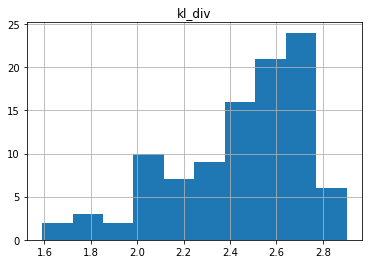

In [6]:
analysis.results_df.hist("kl_div")

In [7]:
config = analysis.best_result["config"]
model = models.seiird(**config)

In [8]:
covid_data_india_by_state = data_utils.load_covid_data_india()
covid_data_mh = covid_data_india_by_state.get(state)

In [9]:
def plot_covid_data_state(covid_df: Dict[str, pd.DataFrame], state: str, start_date=None):
    state_data = covid_df[state]
    if start_date is not None:
        state_data = covid_df[state].loc[covid_df[state].Date > start_date]
    ax = state_data.plot(x="Date", y=["Confirmed", "Cured", "Deaths"], figsize=(12, 8), title=state)
    ax.minorticks_on()
    ax.grid(True, which='major', linestyle='-', linewidth=0.25, axis='both', alpha=0.85, color="black")
    ax.grid(True, which='minor', linestyle='-.', linewidth=0.25, axis='both', alpha=0.7)

In [10]:
start_mh = covid_data_mh[covid_data_mh.Date == start_date].iloc[-1]
I0 = int(start_mh.Confirmed - (start_mh.Cured + start_mh.Deaths))
R0 = (start_mh.Cured)
D0 = start_mh.Deaths

In [11]:
model.simulate(
    timesteps=covid_data_mh[covid_data_mh.Date >= start_date].shape[0] - 1,
    t_min=1,
    start_date=start_date.date(),
    S=MH_pop-I0,
    E=0,
    Is=int(I0*config["p_a"]),
    Ia=int(I0*(1 - config["p_a"])),
    R=R0,
    D=D0
)

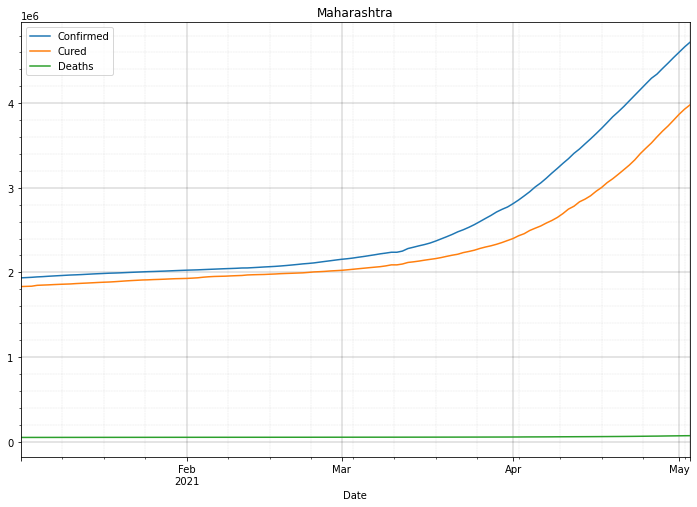

In [12]:
plot_covid_data_state(covid_data_india_by_state, state=state, start_date=start_date)

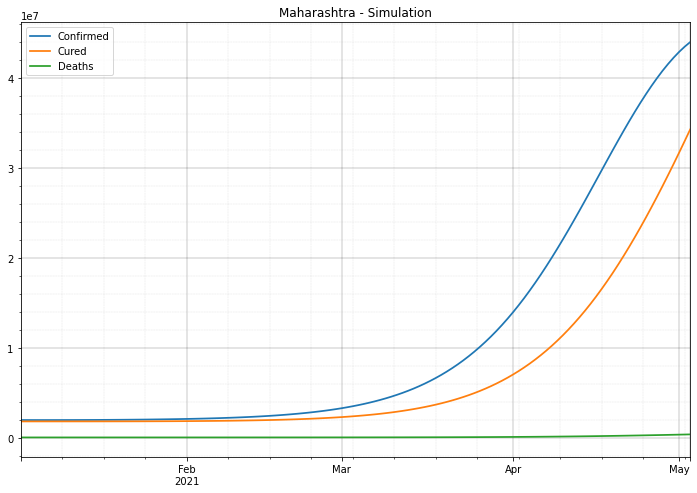

In [13]:
res = pd.DataFrame({
    "Confirmed": model.Ia + model.Is + start_mh.Confirmed,
    "Cured": model.R,
    "Deaths": model.D
})
ax1 = res.plot(figsize=(12, 8), linewidth=1.75, title=f"{state} - Simulation")
ax1.legend(['Confirmed', 'Cured', 'Deaths'])
ax1.minorticks_on()
ax1.grid(True, which='major', linestyle='-', linewidth=0.25, axis='both', alpha=0.85, color="black")
ax1.grid(True, which='minor', linestyle='-.', linewidth=0.25, axis='both', alpha=0.7)

In [14]:
config

{'beta': 0.9072251023073589,
 'p_a': 0.6673792523554036,
 'r_b': 0.39356944896855844,
 'eps': 0.07174096123608976,
 'mu': 0.032208037088499494,
 'rho': 0.0007972995552601445,
 'p_d': 0.030337585340947514}

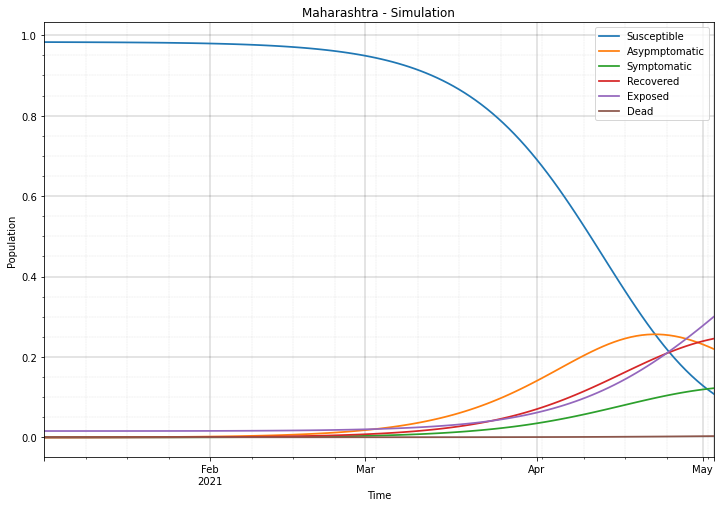

In [16]:
ax0 = model.plot(normed=True, figsize=(12, 8), linewidth=1.75, title=f"{state} - Simulation")
ax0.legend(['Susceptible', 'Asypmptomatic', 'Symptomatic', 'Recovered', 'Exposed', 'Dead'])